# Homework 4
## DSE 220: Machine Learning
## Due Date: 28 May 2017
## Orysya Stus

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Overview
The large number of English words can make language-based applications daunting. To cope with this, it is helpful to have a clustering or embedding of these words, so that words with similar meanings are clustered together, or have embedding that are close to one another. 

But how can we get at the meanings of words? John Firth (1957) put it thus:
You shall know a word by the company it keeps.

That is, words that tend to appear in similar contexts are likely to be related. In this assignment, you will investigate this idea by coming up with an embedding of words that is based on co-occurrence statistics.

The description here assumes you are using Python with NLTK.

1.First, download the Brown corpus (using nltk.corpus). This is a collection of text samples from a wide range of sources, with a total of over a million words. Calling brown.words() returns this text in one long list, which is useful.

http://www.nltk.org/book/ch02.html

In [2]:
from nltk.corpus import brown
word_list = brown.words()
print('There are', len(word_list), 'words in the Brown corpus.')

There are 1161192 words in the Brown corpus.


2.Remove stopwords and punctuation, make everything lowercase, and count how often each word occurs. Use this to come up with two lists:

    A vocabulary V , consisting of a few thousand (e.g., 5000) of the most commonly-occurring words.
    
    A shorter list C of at most 1000 of the most commonly-occurring words, which we shall call context words.

In [3]:
from nltk.corpus import stopwords
import string
word_list = [''.join(c for c in s if c not in string.punctuation) for s in word_list]
word_list = [w.lower() for w in word_list if w != '']
print ('There are', len(word_list), 'words when punctuation is removed.')
word_list = [word for word in word_list if word not in stopwords.words('english')]
print ('There are', len(word_list), 'words when stopwords are removed.')

There are 1013319 words when punctuation is removed.
There are 539921 words when stopwords are removed.


In [4]:
import operator
Dict = {}
def freq_counter(List):
    for w in List:
        if w in Dict.keys():
            Dict[w]+=1
        else:
            Dict[w]=1
freq_counter(word_list)
sorted_counts = sorted(Dict.items(), key=operator.itemgetter(1), reverse=True)

In [5]:
V = [x[0] for x in sorted_counts[:5000]]
C = [x[0] for x in sorted_counts[:1000]]

3.For each word w 2 V , and each occurrence of it in the text stream, look at the surrounding window of four words (two before, two after):
        w1 w2 w w3 w4:
        
Keep count of how often context words from C appear in these positions around word w. That is, for w 2 V , c 2 C, define n(w; c) = # of times c occurs in a window around w:

Using these counts, construct the probability distribution Pr(cjw) of context words around w (for each winV ), as well as the overall distribution Pr(c) of context words. These are distributions over C.

In [6]:
n_wc = np.zeros((5000, 1000))
for w in V:
    V_index = [i for i,val in enumerate(V) if val==w]
    kmers = []
    indices = [i for i,val in enumerate(word_list) if val==w]
    for i in indices:
        if i == 0:
            kmer = word_list[i+1:i+3]
        elif i == 1:
            kmer = word_list[i-1:i] + word_list[i+1:i+3]
        else:
            kmer = word_list[i-2:i] + word_list[i+1:i+3]
        kmers.append(kmer)
    for kmer in kmers:
        for word in kmer:
            if word in C:
                C_index = [i for i,val in enumerate(C) if val==word]
                n_wc[V_index, C_index] += 1
            else:
                pass

In [7]:
Pr_cw = n_wc/n_wc.sum(axis=1, keepdims=True)

In [8]:
c = n_wc.sum(axis=0)
total_Cs = c.sum()
Pr_c = c/total_Cs

In [9]:
df_Pr_cw = pd.DataFrame(Pr_cw, index=V, columns=C)

4.Represent each vocabulary item w by a |C|-dimensional vector phi(w), whose c'th coordinate is:

phi(w) = max(0; log(Pr(cjw)/Pr(c)))

This is known as the (positive) pointwise mutual information, and has been quite successful in work on word embedding.

In [10]:
phi_w = log(Pr_cw/Pr_c)
phi_w[phi_w < 0] = 0

C:\Users\Orysya\Anaconda\envs\py36\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


5.Suppose we want a 100-dimensional representation. How would you achieve this?

### Let's try both PCA & Isomap. Determine the behavior of the data.

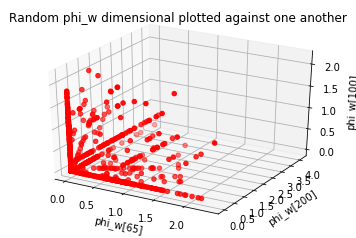

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(phi_w[65], phi_w[200], phi_w[100], c='r', marker='o')
ax.set_xlabel('phi_w[65]')
ax.set_ylabel('phi_w[200]')
ax.set_zlabel('phi_w[100]')
ax.set_title('Random phi_w dimensional plotted against one another')

## Using PCA Word Embedding

In [12]:
%%time
from sklearn.decomposition import PCA
df_phi_w = pd.DataFrame(phi_w, index=V, columns=C)
pca = PCA(n_components=100, random_state=10)
pca_phi_w = pca.fit_transform(phi_w)
pca_phi_w = pd.DataFrame(pca_phi_w, index=V)
print('For PCA(100), ', np.sum(pca.explained_variance_ratio_)* 100.0, '% of the variance is explained.')

For PCA(100),  22.5279951136 % of the variance is explained.
Wall time: 1.11 s


In [13]:
inverse = pca.inverse_transform(pca_phi_w)
residuals = phi_w - inverse
print('The value of the residuals are', np.sum(residuals))

The value of the residuals are 3.50492967982e-11


In [14]:
pca_phi_w.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,...,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03,5.000000e+03
mean,1.865175e-17,2.364509e-15,3.080203e-16,-1.831701e-16,1.060929e-16,-2.494005e-16,-2.374156e-16,7.764900e-17,1.593614e-16,-1.452616e-16,...,2.266853e-16,8.663070e-17,1.384137e-15,2.815748e-16,3.958944e-16,-2.433165e-16,-2.962103e-16,3.031242e-16,8.922307e-17,8.881784e-20
std,2.407444e+00,1.998290e+00,1.703317e+00,1.550785e+00,1.386586e+00,1.307148e+00,1.222200e+00,1.126710e+00,1.067780e+00,1.040223e+00,...,7.603851e-01,7.597314e-01,7.578086e-01,7.556157e-01,7.552909e-01,7.542668e-01,7.531282e-01,7.503733e-01,7.484642e-01,7.458156e-01
min,-6.531506e+00,-4.199833e+00,-4.457408e+00,-6.433364e+00,-5.973243e+00,-6.324674e+00,-5.547327e+00,-4.264628e+00,-4.014826e+00,-4.409083e+00,...,-2.950960e+00,-2.774116e+00,-2.964321e+00,-2.903853e+00,-3.221803e+00,-2.353326e+00,-2.966951e+00,-2.961572e+00,-2.936715e+00,-2.447637e+00
25%,-1.635942e+00,-1.533503e+00,-1.174379e+00,-9.942238e-01,-8.220204e-01,-8.119254e-01,-6.903746e-01,-7.176692e-01,-6.610763e-01,-6.785218e-01,...,-5.129799e-01,-5.177816e-01,-5.120265e-01,-5.011418e-01,-4.937995e-01,-5.193537e-01,-5.123768e-01,-4.944566e-01,-4.844171e-01,-5.183131e-01
50%,1.112506e-02,-4.506111e-01,-1.645531e-01,-3.988574e-02,2.322247e-02,-5.505757e-02,-3.382624e-02,-1.408204e-02,-1.004692e-02,-3.683694e-02,...,-7.787032e-04,1.026889e-03,-1.678705e-02,1.075668e-02,1.230335e-02,7.507133e-03,5.448310e-03,7.685597e-03,1.435372e-02,3.042602e-03
75%,1.519535e+00,1.282448e+00,9.710096e-01,9.055626e-01,8.572364e-01,7.479708e-01,6.460865e-01,7.029351e-01,6.556959e-01,6.376581e-01,...,5.013375e-01,5.006446e-01,5.039164e-01,5.095619e-01,4.922657e-01,5.130505e-01,4.952517e-01,4.972821e-01,4.932897e-01,5.070383e-01
max,7.832885e+00,6.077976e+00,8.600826e+00,6.459332e+00,6.222003e+00,6.489963e+00,9.459273e+00,5.338706e+00,5.244219e+00,5.083382e+00,...,3.035947e+00,3.783355e+00,3.046229e+00,2.977858e+00,3.371020e+00,3.593746e+00,3.095844e+00,3.383182e+00,2.988293e+00,3.094845e+00


6.Investigate the resulting embedding in two ways:
    
     Cluster the vocabulary into 100 clusters. Look them over; do they seem completely random, or is there some sense to them?
     Try finding the nearest neighbor of selected words. Do the answers make sense?

In [15]:
from sklearn.cluster import KMeans
inits = range(1, 20)
inertias = []
for i in inits:
    kmeans = KMeans(n_init=i, n_clusters=100, max_iter= 1000, init='k-means++', random_state=0).fit(pca_phi_w)
    inert = kmeans.inertia_
    inertias.append(inert)

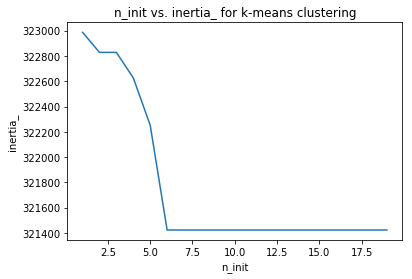

In [16]:
plt.plot(inits, inertias)
plt.title('n_init vs. inertia_ for k-means clustering')
plt.xlabel('n_init')
plt.ylabel('inertia_')

In [17]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_init=6, n_clusters=100, max_iter= 1000, init='k-means++', random_state=0).fit(pca_phi_w)
grouping = {i:[] for i in range(0,100)}

for i,w in enumerate(V):
    grouping[kmeans.labels_[i]].append(w)

In [18]:
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10,20

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage

def cluster_nearest_neighbor(cluster_index):
    cluster = grouping[cluster_index]
    print('For grouping', cluster_index, 'there are', len(cluster), 'words in the cluster: \n', cluster)
    indices = []
    for word in cluster:
        ind = [i for i,val in enumerate(pca_phi_w.index) if val==word][0]
        indices.append(ind) 
    subset = pca_phi_w.ix[indices]
    classes = subset.index
    Z = linkage(subset, 'ward')
    
    plt.title('Hierarchical Clustering of Cluster Words')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(Z, labels= classes, orientation='right')
    plt.show()

In [20]:
from sklearn.neighbors import NearestNeighbors

def knearest_neighbors(word_list):
    for word in word_list:
        subset = pca_phi_w.drop(word)
        neigh = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine')
        neigh.fit(subset)
        distance = neigh.kneighbors(pca_phi_w[pca_phi_w.index == word])[0]
        nearest_neighbor_index = neigh.kneighbors(pca_phi_w[pca_phi_w.index == word])[1]
        print('Word:', word, '-- Nearest neighbor:', subset.index[nearest_neighbor_index][0][0], '-- Distance:', distance[0][0])

7.The Brown corpus is very small. Current work on word embedding uses data sets that are several orders of magnitude larger, but the methodology is along the same lines.

### 1. A description of your 100-dimensional embedding. 
The description should be concise and clear, and should make it obvious exactly what steps you took to obtain your word embeddings. Below, we will denote these as Ψ(w) ∈ R100, for w ∈ V . Also clarify exactly how you selected the vocabulary V and the context words C.

### 2. Nearest neighbor results.
Pick a collection of 25 words w ∈ V . For each w, return its nearest neighbor w' != w in V. A popular distance measure to use for this is cosine distance:

1 − (Ψ(w).Ψ(w'))/ (||Ψ(w)|| ||Ψ(w')||)

Here are some suggestions for words you might choose:
communism, autumn, cigarette, pulmonary, mankind, africa, chicago, revolution, september, chemical, detergent, dictionary, storm, worship

Do the results make any sense? You can use other distance measures apart from cosine distance to improve the results.

In [21]:
words = ['communism', 'autumn', 'cigarette', 'pulmonary', 'mankind', 'africa', 'chicago', 'revolution', 'september', 'chemical', 'detergent', 'dictionary', 'storm', 'worship', 'money', 'red', 'vacation', 'missile', 'player', 'velocity', 'reality', 'education', 'strong', 'churches', 'world' ]
knearest_neighbors(words)

Word: communism -- Nearest neighbor: utopian -- Distance: 0.618788623478
Word: autumn -- Nearest neighbor: storm -- Distance: 0.515481120469
Word: cigarette -- Nearest neighbor: bullet -- Distance: 0.509093821293
Word: pulmonary -- Nearest neighbor: artery -- Distance: 0.256579170491
Word: mankind -- Nearest neighbor: world -- Distance: 0.538521909205
Word: africa -- Nearest neighbor: asia -- Distance: 0.358373805583
Word: chicago -- Nearest neighbor: portland -- Distance: 0.483564007709
Word: revolution -- Nearest neighbor: modern -- Distance: 0.633185238013
Word: september -- Nearest neighbor: july -- Distance: 0.233969560906
Word: chemical -- Nearest neighbor: drugs -- Distance: 0.476249972519
Word: detergent -- Nearest neighbor: fabrics -- Distance: 0.4881330922
Word: dictionary -- Nearest neighbor: text -- Distance: 0.276896053425
Word: storm -- Nearest neighbor: saturday -- Distance: 0.515346722166
Word: worship -- Nearest neighbor: christian -- Distance: 0.498514492007
Word: mon

### 3. Clustering.
Using the vectorial representation Ψ(.), cluster the words in V into 100 groups. Clearly specify what algorithm and distance function you using for this, and the reasons for your choices.

Look over the resulting 100 clusters. Do any of them seem even moderately coherent? Pick out a few of the best clusters and list the words in them.

In [31]:
import json
with open('PCA_transformed.json', 'w') as f:
    json.dump(grouping, f)
# grouping

In [23]:
print('This cluster is associated with scientific studies. \n', grouping[22])
print('\nThis cluster is associated with numeric values or measurement metrics. \n', grouping[16])
print('\nThis cluster is associated with predominanatly with relationship status. \n', grouping[13])
print('\nThis cluster is associated with government associated terminology. \n', grouping[8])
print('\nThis cluster is associated with economic terminology. \n', grouping[4])

This cluster is associated with scientific studies. 
 ['information', 'study', 'data', 'results', 'methods', 'reaction', 'described', 'studies', 'cells', 'selected']

This cluster is associated with numeric values or measurement metrics. 
 ['two', 'years', 'three', 'several', 'four', 'five', 'ago', 'six', 'minutes', 'miles', 'hundred', 'ten', 'couple', 'seven', 'eight', 'dollars', 'thousand', 'nine', 'twenty', 'fifty', 'thirty', 'fifteen', 'twelve', 'eleven', 'forty', 'fourteen']

This cluster is associated with predominanatly with relationship status. 
 ['man', 'old', 'young', 'wife', 'mother', 'father', 'son', 'friend', 'met', 'husband', 'lived', 'poor', 'hospital', 'married', 'jack', 'spoke', 'died', 'captain', 'named', 'remembered', 'lady', 'murder', 'brother', 'daughter', 'mercer', 'smiled', 'sweet', 'fellow', 'baby', 'wilson', 'talked', 'lewis', 'wondered', 'fathers', 'uncle', 'alive', 'loved', 'joe', 'wished', 'dear', 'alfred', 'warren', 'cousin', 'sick', 'lucy', 'younger', 'ada

For grouping 8 there are 12 words in the cluster: 
 ['program', 'national', 'education', 'defense', 'medical', 'aid', 'planning', 'activities', 'assistance', 'educational', 'policies', 'longterm']


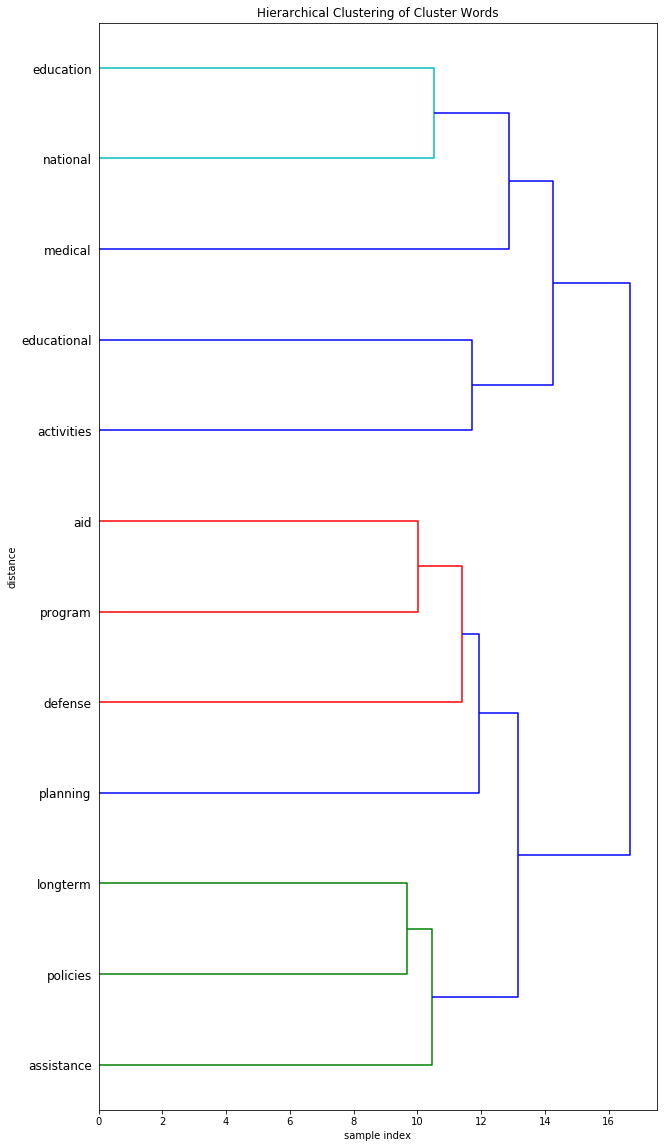

In [24]:
cluster_nearest_neighbor(8)

## Using Isomap Word Embedding

In [25]:
%%time
from sklearn.manifold import Isomap
isomap = Isomap(n_components= 100, n_neighbors=5)
isomap.fit_transform(phi_w)

Wall time: 5min 1s


In [26]:
data = isomap.embedding_
data = pd.DataFrame(data, index=V)
print('The isomap reconstruction error is', isomap.reconstruction_error())

The isomap reconstruction error is 30.3704030842


### 2. Nearest neighbor results.

In [27]:
def knearest_neighbors(word_list):
    for word in word_list:
        subset = data.drop(word)
        neigh = NearestNeighbors(n_neighbors=1, algorithm='brute', metric='cosine')
        neigh.fit(subset)
        distance = neigh.kneighbors(data[data.index == word])[0]
        nearest_neighbor_index = neigh.kneighbors(data[data.index == word])[1]
        print('Word:', word, '-- Nearest neighbor:', subset.index[nearest_neighbor_index][0][0], '-- Distance:', distance[0][0])

In [28]:
knearest_neighbors(words)

Word: communism -- Nearest neighbor: reading -- Distance: 0.146721966519
Word: autumn -- Nearest neighbor: architect -- Distance: 0.000559851345542
Word: cigarette -- Nearest neighbor: marshal -- Distance: 0.290426801564
Word: pulmonary -- Nearest neighbor: explanation -- Distance: 0.133498779694
Word: mankind -- Nearest neighbor: recognize -- Distance: 0.00175402580933
Word: africa -- Nearest neighbor: jurisdiction -- Distance: 0.130636400126
Word: chicago -- Nearest neighbor: departments -- Distance: 0.042895707476
Word: revolution -- Nearest neighbor: journal -- Distance: 0.00453089797812
Word: september -- Nearest neighbor: august -- Distance: 0.0111746504274
Word: chemical -- Nearest neighbor: grain -- Distance: 0.00048523090647
Word: detergent -- Nearest neighbor: date -- Distance: 0.00558842458655
Word: dictionary -- Nearest neighbor: text -- Distance: 0.0127054762105
Word: storm -- Nearest neighbor: bore -- Distance: 0.000226146833668
Word: worship -- Nearest neighbor: brought 

### 3. Clustering.

In [29]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_init=6, n_clusters=100, max_iter= 1000, init='k-means++', random_state=0).fit(data)
grouping1 = {i:[] for i in range(0,100)}

for i,w in enumerate(V):
    grouping1[kmeans.labels_[i]].append(w)

In [32]:
with open('Isomap_transformed.json', 'w') as f:
    json.dump(grouping1, f)
# grouping1